# 숫자 뒤집기 예제

In [13]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

from transformer import Transformer

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
class ReverseDataset(Dataset):
    def __init__(self, num_samples, min_len, max_len, vocab_size):
        self.num_samples = num_samples
        self.min_len = min_len
        self.max_len = max_len
        self.vocab_size = vocab_size
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # 길이 설정
        seq_len = torch.randint(self.min_len, self.max_len, (1,))
        seq_len = int(seq_len)
        
        # 랜덤 숫자 생성
        # seq = torch.randint(3, self.vocab_size, (seq_len,))
        seq = torch.randint(3, self.vocab_size, (seq_len,))

        # src: <sos> + 숫자 + <eos>
        # tgt: <sos> + 거꾸로 + <eos>
        src = torch.cat([torch.tensor([1]), seq, torch.tensor([2])])
        tgt = torch.cat([torch.tensor([1]), seq.flip(0), torch.tensor([2])])

        # 패딩 (고정 길이 max_len+2)
        full_len = self.max_len + 2
        src_pad = torch.zeros(full_len, dtype=torch.long)
        tgt_pad = torch.zeros(full_len, dtype=torch.long)

        src_pad[:len(src)] = src
        tgt_pad[:len(tgt)] = tgt

        return src_pad, tgt_pad

In [15]:
# --- 설정 값 ---
V_SIZE = 20      # 숫자 종류 (0~19)
MAX_LEN = 16     # 데이터셋 생성 시 최대 길이
BATCH_SIZE = 64
LR = 0.0005
EPOCHS = 20

# 모델 생성 파라미터
# (Reverse Task는 입력과 출력 단어 집합 크기가 같으므로 V_SIZE로 통일)
src_vocab = V_SIZE  
tgt_vocab = V_SIZE
d_model = 32      # 교육용이라 작게 설정
n_layers = 2
n_heads = 4
d_ff = 64
max_len = MAX_LEN + 5 # 여유 있게 설정
pad_idx = 0

# --- 모델 초기화 ---
model = Transformer(
    src_vocab_size=src_vocab, 
    tgt_vocab_size=tgt_vocab, 
    d_model=d_model, 
    n_layers=n_layers, 
    n_heads=n_heads, 
    d_ff=d_ff, 
    max_len=max_len, 
    pad_idx=pad_idx
).to(device)

dataset = ReverseDataset(3000, 5, MAX_LEN, V_SIZE)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# ignore_index = 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
print(f"모델 파라미터 개수: {sum(p.numel() for p in model.parameters())}")

모델 파라미터 개수: 44820


Epoch: 05 | Loss: 1.1164
Epoch: 10 | Loss: 0.9099
Epoch: 15 | Loss: 0.7552
Epoch: 20 | Loss: 0.6212
Epoch: 25 | Loss: 0.5485
Epoch: 30 | Loss: 0.4741
Epoch: 35 | Loss: 0.4099
Epoch: 40 | Loss: 0.3746
Epoch: 45 | Loss: 0.3199
Epoch: 50 | Loss: 0.2956
Epoch: 55 | Loss: 0.2601
Epoch: 60 | Loss: 0.2453
Epoch: 65 | Loss: 0.2099
Epoch: 70 | Loss: 0.2001
Epoch: 75 | Loss: 0.1913
Epoch: 80 | Loss: 0.1806
Epoch: 85 | Loss: 0.1738
Epoch: 90 | Loss: 0.1485
Epoch: 95 | Loss: 0.1365
Epoch: 100 | Loss: 0.1399


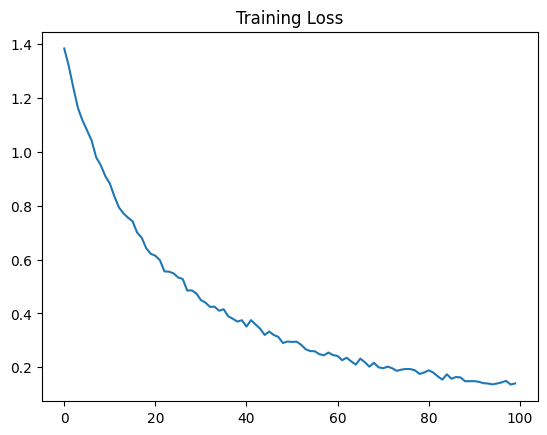

In [21]:
model.train()
loss_history = []
EPOCHS = 100
for epoch in range(EPOCHS):
    total_loss = 0
    
    for src, tgt in dataloader:
        src, tgt = src.to(device), tgt.to (device)

        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        # 1. forward
        logits, _ = model(src, tgt_input)

        # (batch * seqlen, vocab_size)
        loss = criterion(logits.reshape(-1, V_SIZE), tgt_output.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)

    if (epoch+1) % 5 == 0:
        print(f"Epoch: {epoch+1:02d} | Loss: {avg_loss:.4f}")

plt.plot(loss_history)
plt.title("Training Loss")
plt.show()

In [23]:
from transformer import make_pad_mask, make_subsequent_mask

def greedy_decode(model : Transformer, src, max_len, start_symbol, end_symbol):
    model.eval()
    src = src.to(device)

    src_mask = make_pad_mask(src, src, model.pad_idx).to(device)
    src_emb = model.pos_encoder.forward(model.src_embedding(src))
    enc_output = model.encoder.forward(src_emb, src_mask)
    
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)

    for i in range(max_len-1):
        tgt_mask = make_subsequent_mask(ys.size(1)).type(torch.bool).to(device)
        tgt_emb = model.pos_decoder(model.tgt_embedding(ys))

        src_tgt_mask = make_pad_mask(ys, src, model.pad_idx).to(device)

        out, _ = model.decoder.forward(tgt_emb, enc_output, src_tgt_mask, tgt_mask)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == end_symbol:
            break
    return ys

print("테스트")
test_input = torch.tensor([[1, 5, 6, 7, 8, 3, 11, 2]]).to(device)

result_indices = greedy_decode(model, test_input, max_len=10, start_symbol=1, end_symbol=2)

print(f"입력: {test_input[0].tolist()}")
print(f"예측: {result_indices[0].tolist()}")


테스트
입력: [1, 5, 6, 7, 8, 3, 11, 2]
예측: [1, 11, 3, 8, 7, 6, 5, 2]


In [ ]:
def draw_attention_map(src_tokens, tgt_tokens, attn_matrix, head_idx=0):
    """
    src_tokens: 소스 문장 토큰 리스트(ex: ['<sos>', '1', '2', ...])
    tgt_tokens: 타겟 문장 토큰 리스트
    attn_matrix: 모델 가중치 [n_heads, tgt_len, src_len]
    head_idx: 헤드 번호(0~n_heads-1)
    """
    attn_data = attn_matrix[head_idx].detach().cpu().numpy()

    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(attn_data, cmap="viridis") # viridis, plasma, gray, ...

    ax.set_xticks(range(len(src_tokens)))
    ax.set_yticks(range(len(tgt_tokens)))

    ax.set_xticklabels(src_tokens, fontsize=12)
    ax.set_yticklabels(tgt_tokens, fontsize=12)

    ax.xaxis.tick_top()
    plt.title(f"Cross Attention Map (Head {head_idx})", pad=20)
    plt.xlabel("Source (Input)", labelpad=10)
    plt.ylabel("Target (Output)", labelpad=10)
    
    # 컬러바 추가
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.show()

In [ ]:
from transformer import Transformer

# --- 하이퍼파라미터 ---
V_SIZE = 20    # 숫자 종류 (0~19)
MAX_LEN = 16   # 숫자 시퀀스 최대 길이
BATCH_SIZE = 64
LR = 0.0005
EPOCHS = 20

# 모델 파라미터 설정
src_vocab = 100
tgt_vocab = 100
d_model = 32
n_layers = 2
n_heads = 4
d_ff = 64
max_len = 20
pad_idx = 0

model = Transformer(src_vocab, tgt_vocab, d_model, n_layers, n_heads, d_ff, 
                    max_len, pad_idx)

In [ ]:
# 1. 테스트 데이터
# 입력: <sos>(1) + [4,5,6,7] + <eos>(2)
device = "cpu"
src_seq = [1, 4, 5, 6, 7, 2]
tgt_seq = [1, 7, 6, 5, 4, 2]

src_tensor = torch.tensor([src_seq]).to(device)
tgt_tensor = torch.tensor([src_seq]).to(device)

# 2. 모델 실행 (Forward)
model.eval()
with torch.no_grad():
    # Teacher forcing, attention map 가져옴
    # 학습된 가중치 확인
    logits, attn_weights = model(src_tensor, tgt_tensor[:, :-1])

# 3. 차원 확인
# attn_weight shape: [batch, n_head, tgt_len, src_len]
print(f"Attention weight shape: {attn_weights.shape}")

Attention weight shape: torch.Size([1, 4, 5, 6])


In [ ]:
import matplotlib.pyplot as plt

# --- 1. 축에 표시할 라벨 만들기 (숫자 -> 문자열) ---
# src: <sos>, 4, 5, 6, 7, <eos>
# tgt: <sos>, 7, 6, 5, 4 (마지막 <eos>는 입력으로 안 들어갔으므로 제외)
src_labels = [str(x) for x in src_seq]
tgt_labels = [str(x) for x in tgt_seq[:-1]] 

# --- 2. 배치 차원 제거 ---
# 모델 출력: [batch, n_heads, tgt_len, src_len] -> [1, 4, 5, 6]
# 그리기 함수 입력: [n_heads, tgt_len, src_len] -> [4, 5, 6]
# 0번째 배치의 데이터를 가져옵니다.
attention_matrix = attn_weights[0]

# --- 3. 함수 호출 (그림 그리기) ---
# 헤드 0번이 어디를 보는지 확인
draw_attention_map(src_labels, tgt_labels, attention_matrix, head_idx=0)

# 다른 헤드도 보고 싶다면?
# draw_attention_map(src_labels, tgt_labels, attention_matrix, head_idx=1)